In [117]:
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import matplotlib.pyplot as plt

Let us generate some dummy data.

In [118]:
def generate(key, n, m):
    x_0 = jax.random.normal(key, (n, n))
    x_hist = jnp.zeros((m, n, n))

    window = jax.random.normal(key, (n, n))

    # diffuse the initial condition over time with random kernel
    x = x_0
    for i in range(m):
        x = x + 0.1 * jsp.signal.correlate(x, window, mode='same')
    
        x_hist = x_hist.at[i, :].set(x)

    # unsqueeze
    x_hist = x_hist.reshape((m, n, n, 1))

    return x_hist

n = 16
m = 50
key = jax.random.PRNGKey(0)
data = generate(key, n, m)

print(data.shape)

(50, 16, 16, 1)


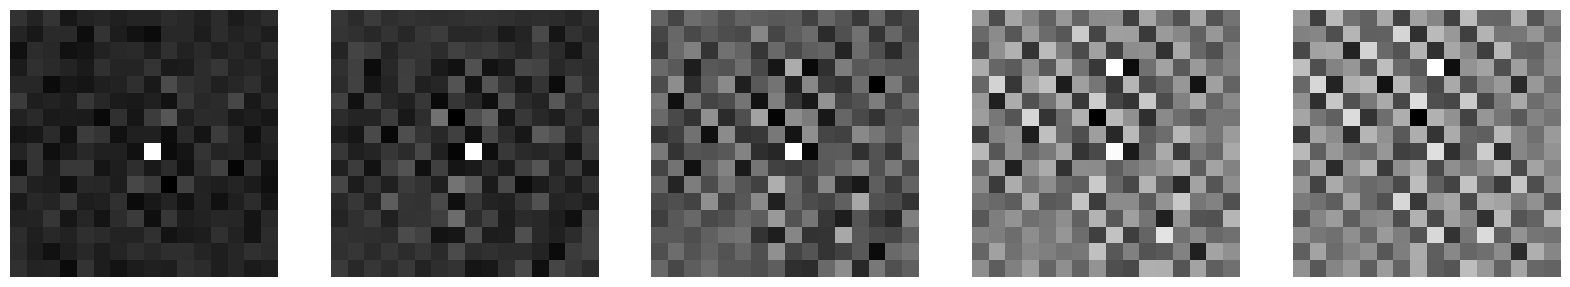

In [119]:
# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(data[i], cmap='gray')
    axs[i].axis('off')

In [108]:
from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct
import optax

In [120]:
class Encoder(nn.Module):

    def setup(self):
        self.conv1 = nn.Conv(features=4, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=16, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [121]:
class Decoder(nn.Module):

    def setup(self):
        self.conv1 = nn.ConvTranspose(features=8, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.ConvTranspose(features=4, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [122]:
class Autoencoder(nn.Module):

    def setup(self):
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def __call__(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [235]:
def create_train_state(module : Autoencoder, rng : jax.random.PRNGKey, n : int, learning_rate : float):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, n, n, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.adam(learning_rate=learning_rate)
  return train_state.TrainState.create(
      apply_fn=module.apply, params=params, tx=tx)

In [239]:
def reconstruction_loss(params, state, images):
  prediction = state.apply_fn({'params': params}, images)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.square(prediction - images))
  return loss

@jax.jit
def train_step(state, images):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(state.params, state, images)

  state = state.apply_gradients(grads=grads)
  return loss, state


In [242]:
init_rng = jax.random.key(0)

learning_rate = 0.0001

autoencoder = Autoencoder()

# test prediction
state = create_train_state(autoencoder, init_rng, n, learning_rate)

num_epochs = 1

for epoch in range(num_epochs):

    loss_sum = 0
    for i in range(data.shape[0]):
        loss, state = train_step(state, data[i])
        print(loss)
        loss_sum += loss

    print(f'epoch {epoch}, loss {loss_sum / data.shape[0]}')
